In [1]:
import numpy as np
import math
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from PIL import Image
import os
import os.path
import errno
import codecs
import copy

In [2]:
torch.manual_seed(0)
np.random.seed(0)
print("torch.cuda.device_count()", torch.cuda.device_count())
print("torch.cuda.current_device()", torch.cuda.current_device())
torch.cuda.set_device(3)
print("torch.cuda.current_device()", torch.cuda.current_device())

torch.cuda.device_count() 4
torch.cuda.current_device() 0
torch.cuda.current_device() 3


In [17]:
def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255):          # population size

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.popsize = popsize

    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize})

  def rms_stdev(self):
    sigma = self.es.result[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = reward_table_result
    self.es.tell(self.solutions, (-reward_table).tolist()) # convert minimizer to maximizer.

  def done(self):
    return self.es.stop()

  def current_param(self):
    return self.es.result[5] # mean solution, presumably better with noise
  
  def best_param(self):
    return self.es.result[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result
    return (r[0], -r[1], -r[1], r[6])

class SimpleES:
  '''Simple Evolution Strategies.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               sigma_alpha=0.20,      # learning rate for standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               done_threshold=1e-6,   # threshold when we say we are done
               average_baseline=True, # set baseline to average of batch
               forget_best=True):     # only use the best from latest generation

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize & 2), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)
    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)
    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.done_threshold = done_threshold

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = reward_table_result

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # adaptive sigma
    # normalization
    stdev_reward = reward.std()
    epsilon = self.epsilon
    sigma = self.sigma
    S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
    reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
    rS = reward_avg - b
    delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

    # move mean to the average of the best idx means
    self.mu += self.epsilon_full[idx].mean(axis=0)

    # adjust sigma according to the adaptive sigma calculation
    change_sigma = self.sigma_alpha * delta_sigma
    change_sigma = np.minimum(change_sigma, self.sigma)
    change_sigma = np.maximum(change_sigma, - 0.5 * self.sigma)
    self.sigma += change_sigma
    self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.curr_best_mu
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

class SimpleGA:
  '''Simple Genetic Algorithm.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               done_threshold=1e-6):  # threshold when we say we are done

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize

    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)

    self.sigma = self.sigma_init
    self.elite_params = np.zeros((self.elite_popsize, self.num_params))
    self.elite_rewards = np.zeros(self.elite_popsize)
    self.best_param = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_iteration = True
    self.forget_best = forget_best
    self.done_threshold = done_threshold

  def rms_stdev(self):
    return self.sigma # same sigma for all parameters.

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
    solutions = []
    
    def mate(a, b):
      c = np.copy(a)
      idx = np.where(np.random.rand((c.size)) > 0.5)
      c[idx] = b[idx]
      return c
    
    elite_range = range(self.elite_popsize)
    for i in range(self.popsize):
      idx_a = np.random.choice(elite_range)
      idx_b = np.random.choice(elite_range)
      child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
      solutions.append(child_params + self.epsilon[i])

    solutions = np.array(solutions)
    self.solutions = solutions

    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."
    
    if (not self.forget_best or self.first_iteration):
      reward = reward_table_result
      solution = self.solutions
    else:
      reward = np.concatenate([reward_table_result, self.elite_rewards])
      solution = np.concatenate([self.solutions, self.elite_params])

    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    self.elite_rewards = reward[idx]
    self.elite_params = solution[idx]

    self.curr_best_reward = self.elite_rewards[0]
    
    if self.first_iteration or (self.curr_best_reward > self.best_reward):
      self.first_iteration = False
      self.best_reward = self.elite_rewards[0]
      self.best_param = np.copy(self.elite_params[0])

    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.elite_params[0]

  def best_param(self):
    return self.best_param

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)

class OpenES:
  ''' Basic Version of OpenAI Evolution Strategies.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.1,               # initial standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               learning_rate=0.001,          # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.001,  # stop annealing learning rate
               popsize=255,                  # population size
               antithetic=False,             # whether to use antithetic sampling
               forget_best=True):           # forget historical best

    self.num_params = num_params
    self.sigma_decay = sigma_decay
    self.sigma = sigma_init
    self.sigma_limit = sigma_limit
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.antithetic = antithetic
    if self.antithetic:
      assert (self.popsize & 2), "Population size must be even"
      self.half_popsize = int(self.popsize / 2)

    self.reward = np.zeros(self.popsize)
    self.mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.forget_best = forget_best

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    if self.antithetic:
      self.epsilon_half = np.random.randn(self.half_popsize, self.num_params)
      self.epsilon = np.concatenate([self.epsilon_half, - self.epsilon_half])
    else:
      self.epsilon = np.random.randn(self.popsize, self.num_params)

    self.solutions = self.mu.reshape(1, self.num_params) + self.epsilon * self.sigma

    return self.solutions

  def tell(self, reward):
    # input must be a numpy float array
    assert(len(reward) == self.popsize), "Inconsistent reward_table size reported."

    idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    best_mu = self.solutions[idx[0]]

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # main bit:
    # standardize the rewards to have a gaussian distribution
    normalized_reward = (reward - np.mean(reward)) / np.std(reward)
    self.mu += self.learning_rate/(self.popsize*self.sigma)*np.dot(self.epsilon.T, normalized_reward)

    # adjust sigma according to the adaptive sigma calculation
    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

    if (self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def done(self):
    return False

  def current_param(self):
    return self.curr_best_mu

  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

In [18]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])

In [19]:
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)

In [20]:
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

In [21]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

In [22]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_filter1 = 8
    self.num_filter2 = 16
    self.num_padding = 2
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, self.num_filter1, 5, padding=self.num_padding)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(self.num_filter1, self.num_filter2, 5, padding=self.num_padding)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(self.num_filter2*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_filter2*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x)

In [23]:
NPOPULATION = 101
weight_decay_coef = 0.1

In [24]:
'''
models = []
for i in range(NPOPULATION):
  model = Net()
  if args.cuda:
    model.cuda()
  model.eval()
  models.append(model)
'''

model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

In [25]:
# get init params
orig_params = []
model_shapes = []
for param in orig_model.parameters():
  p = param.data.cpu().numpy()
  model_shapes.append(p.shape)
  orig_params.append(p.flatten())
orig_params_flat = np.concatenate(orig_params)
NPARAMS = len(orig_params_flat)
print(NPARAMS)

11274


In [26]:
def update_model(flat_param, model, model_shapes):
  idx = 0
  i = 0
  for param in model.parameters():
    delta = np.product(model_shapes[i])
    block = flat_param[idx:idx+delta]
    block = np.reshape(block, model_shapes[i])
    i += 1
    idx += delta
    block_data = torch.from_numpy(block).float()
    if args.cuda:
      block_data = block_data.cuda()
    param.data = block_data

In [27]:
def evaluate(model, test_loader, print_mode=True, return_loss=False):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  
  if print_mode:
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * acc))
  
  if return_loss:
    return test_loss
  return acc

In [35]:
"""
es = SimpleES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_alpha=0.2,
              sigma_limit=0.001,
              elite_ratio=0.1,
              average_baseline=False,
              forget_best=True
             )
"""
es = CMAES(NPARAMS, sigma_init=0.01, popsize=NPOPULATION)

(50_w,101)-aCMA-ES (mu_w=27.2,w_1=8%) in dimension 11274 (seed=824008, Mon Aug 14 19:50:15 2017)


In [36]:
def worker(procnum, model, solution, data, target, send_end):
  update_model(solution, model, model_shapes)
  output = model(data)
  loss = F.nll_loss(output, target)
  reward = - loss.data[0]
  send_end.send(reward)

def batch_simulation(model_list, solutions, data, target, process_count):
  jobs = []
  pipe_list = []

  for i in range(process_count):
    recv_end, send_end = mp.Pipe(False)
    p = mp.Process(target=worker, args=(i, model_list[i], solutions[i], data, target, send_end))
    jobs.append(p)
    pipe_list.append(recv_end)

  for p in jobs:
    p.start()

  for p in jobs:
    p.join()

  result_list = [x.recv() for x in pipe_list]
  return np.array(result_list)


def batch_simulation_sequential(model_list, solutions, data, target, process_count):
  result_list = []
  for i in range(process_count):
    update_model(solutions[i], model_list[i], model_shapes)
    output = model_list[i](data)
    loss = F.nll_loss(output, target)
    reward = - loss.data[0]
    result_list.append(reward)
  return np.array(result_list)


In [37]:
#'''
best_valid_acc = 0
training_log = []
for epoch in range(1, 10*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.data[0]

    best_raw_reward = reward.max()
    #reward = compute_centered_ranks(reward)
    #l2_decay = compute_weight_decay(weight_decay_coef, solutions)
    #reward += l2_decay

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 5 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), result[3].mean())

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)
#'''

1 0 -2.30188655853 -0.000104220946267 0.00997634615744
1 5 -2.30154514313 -8.84061715779e-06 0.00986652493537
1 10 -2.30042457581 0.000152815991869 0.0097671816071
1 15 -2.29986000061 0.000268667177688 0.00967575199719
1 20 -2.29250359535 0.000427199407633 0.0095904954213
1 25 -2.28641533852 0.000454197834952 0.00951065872441
1 30 -2.27578568459 0.000373592603108 0.00943559522572
1 35 -2.25599741936 0.000583757802138 0.00936481786393
1 40 -2.23393464088 0.000605808365844 0.00929836381506
1 45 -2.20563745499 0.000878342698827 0.00923578167451
1 50 -2.15085124969 0.00102741648315 0.0091768468182
1 55 -2.11342811584 0.00114535202013 0.00912102638875
valid_acc 50.94833333333333
best valid_acc 50.94833333333333
2 0 -2.04475855827 0.00124462044262 0.00906841210485
2 5 -1.96643698215 0.00139885140467 0.00901885145178
2 10 -1.92456114292 0.00150639932673 0.00897198282647
2 15 -1.84836673737 0.0014787042054 0.00892804404344
2 20 -1.76283228397 0.00166931656861 0.00888666918016
2 25 -1.652027845

12 40 -0.368787884712 0.00347125438557 0.00840779767934
12 45 -0.399945020676 0.00347125438557 0.00840993451063
12 50 -0.389169663191 0.00347125438557 0.00841218920854
12 55 -0.356613248587 0.00347125438557 0.00841441264921
valid_acc 88.92
best valid_acc 88.92
13 0 -0.409674197435 0.00347125438557 0.00841665073356
13 5 -0.38014036417 0.00347125438557 0.00841904165577
13 10 -0.38029807806 0.00347125438557 0.00842130798683
13 15 -0.401214748621 0.00347125438557 0.00842335753393
13 20 -0.337412327528 0.00353673239652 0.00842541998724
13 25 -0.358988970518 0.00353673239652 0.00842752978508
13 30 -0.385317146778 0.00353673239652 0.00842950102561
13 35 -0.380937457085 0.00353673239652 0.0084313551979
13 40 -0.329854160547 0.00353673239652 0.00843326451968
13 45 -0.408561378717 0.00353673239652 0.0084351830257
13 50 -0.385018527508 0.00353673239652 0.0084371502158
13 55 -0.368632793427 0.00353673239652 0.00843925457767
valid_acc 89.47666666666667
best valid_acc 89.47666666666667
14 0 -0.41351

24 0 -0.293299794197 0.00246061243544 0.0086149970754
24 5 -0.223264634609 0.00246061243544 0.00861584524689
24 10 -0.24683688581 0.00246061243544 0.00861659091855
24 15 -0.263349086046 0.00246061243544 0.00861754874178
24 20 -0.216732054949 0.00246061243544 0.00861850325544
24 25 -0.2348626405 0.00246061243544 0.00861953219551
24 30 -0.234241724014 0.00246061243544 0.00862057417281
24 35 -0.250381141901 0.00246061243544 0.00862158699939
24 40 -0.264840096235 0.00246061243544 0.0086223955385
24 45 -0.256871283054 0.00203111159738 0.00862309556577
24 50 -0.273311078548 0.00203111159738 0.00862397940269
24 55 -0.238712206483 0.00203111159738 0.00862477950742
valid_acc 93.17999999999999
best valid_acc 93.17999999999999
25 0 -0.258232116699 0.00203111159738 0.00862562197467
25 5 -0.263939857483 0.00203111159738 0.00862625183666
25 10 -0.212182253599 0.00203111159738 0.00862666167763
25 15 -0.226712763309 0.00203111159738 0.00862691516008
25 20 -0.241672381759 0.00203111159738 0.00862718918

35 30 -0.149749964476 0.00271467467095 0.00863684185053
35 35 -0.159742504358 0.00271467467095 0.00863615819735
35 40 -0.128976076841 0.00271467467095 0.00863550936104
35 45 -0.15264955163 0.00271467467095 0.00863499683152
35 50 -0.164067521691 0.00271467467095 0.00863475798371
35 55 -0.144628629088 0.00271467467095 0.00863449360725
valid_acc 94.96166666666667
best valid_acc 94.96166666666667
36 0 -0.188382431865 0.00271467467095 0.00863445284221
36 5 -0.159257903695 0.00271467467095 0.00863468149396
36 10 -0.161554083228 0.00271467467095 0.00863509343285
36 15 -0.197679921985 0.00271467467095 0.00863566499484
36 20 -0.192334368825 0.00289385710066 0.00863650004802
36 25 -0.143461883068 0.00289385710066 0.00863728846463
36 30 -0.190130904317 0.00289385710066 0.00863800554381
36 35 -0.137236729264 0.00289385710066 0.00863867483866
36 40 -0.175755679607 0.00289385710066 0.00863931150323
36 45 -0.224015012383 0.00289385710066 0.00864002938701
36 50 -0.155479073524 0.00289385710066 0.00864

valid_acc 95.905
47 0 -0.133553355932 0.00266663181333 0.00863888627134
47 5 -0.135017186403 0.00266663181333 0.00863865360115
47 10 -0.120845779777 0.00266663181333 0.00863849217871
47 15 -0.127971023321 0.00266663181333 0.00863837726356
47 20 -0.160439863801 0.00266663181333 0.00863840834489
47 25 -0.122789308429 0.00266663181333 0.00863831270677
47 30 -0.143059760332 0.00175738811011 0.0086381547545
47 35 -0.174086123705 0.00175738811011 0.0086382779807
47 40 -0.102100208402 0.00175738811011 0.00863853918736
47 45 -0.112652048469 0.00175738811011 0.00863889734768
47 50 -0.12760232389 0.00175738811011 0.00863915612046
47 55 -0.123700983822 0.00175738811011 0.00863933362564
valid_acc 96.015
best valid_acc 96.015
48 0 -0.104921407998 0.00175738811011 0.00863965190557
48 5 -0.132464423776 0.00175738811011 0.00864006663413
48 10 -0.134943589568 0.00175738811011 0.00864051120807
48 15 -0.125684767962 0.00175738811011 0.00864104548426
48 20 -0.0977127552032 0.00175738811011 0.0086416175183

58 25 -0.112217515707 0.0021122790016 0.00860729387172
58 30 -0.104678533971 0.0021122790016 0.00860655993027
58 35 -0.114505372941 0.0021122790016 0.0086060757498
58 40 -0.0942439287901 0.0021122790016 0.00860566882003
58 45 -0.111011914909 0.0021122790016 0.00860544877903
58 50 -0.105483844876 0.0021122790016 0.00860525561413
58 55 -0.123141109943 0.0021122790016 0.00860511221953
valid_acc 96.63333333333334
best valid_acc 96.63333333333334
59 0 -0.11253798008 0.0021122790016 0.00860499113579
59 5 -0.159926474094 0.0021122790016 0.00860486730035
59 10 -0.112486928701 0.0021122790016 0.0086045752407
59 15 -0.097209610045 0.0021122790016 0.00860438057331
59 20 -0.117390230298 0.0021122790016 0.00860405933947
59 25 -0.0937673673034 0.0021122790016 0.0086036908422
59 30 -0.105257540941 0.0021122790016 0.00860336573475
59 35 -0.113285526633 0.0021122790016 0.00860309709535
59 40 -0.102194152772 0.0021122790016 0.00860297489577
59 45 -0.119906328619 0.0021122790016 0.00860294676034
59 50 -0

69 55 -0.117777265608 0.00192444170128 0.00866008561499
valid_acc 96.985
70 0 -0.146237581968 0.00192444170128 0.00866022638647
70 5 -0.0995063707232 0.00192444170128 0.00866047129629
70 10 -0.125203356147 0.00192444170128 0.00866062418993
70 15 -0.0781003013253 0.00192444170128 0.00866073566851
70 20 -0.111474618316 0.00192444170128 0.00866062480446
70 25 -0.0831215530634 0.00192444170128 0.00866022369139
70 30 -0.0858686640859 0.00192444170128 0.00865987720952
70 35 -0.11687541008 0.00192444170128 0.00865948570481
70 40 -0.120572656393 0.00192444170128 0.0086591368903
70 45 -0.106399551034 0.00192444170128 0.00865894685068
70 50 -0.087506107986 0.00192444170128 0.00865895051082
70 55 -0.121603310108 0.00192444170128 0.00865869667468
valid_acc 97.005
71 0 -0.108841709793 0.00192444170128 0.00865844986351
71 5 -0.0665321201086 0.00192444170128 0.00865826283142
71 10 -0.107123568654 0.00192444170128 0.00865795606699
71 15 -0.1049657166 0.00192444170128 0.00865792451026
71 20 -0.08944272

81 40 -0.0975609049201 0.00144392304637 0.00864782138902
81 45 -0.124054789543 0.00144392304637 0.00864721804031
81 50 -0.100183710456 0.00144392304637 0.00864664288441
81 55 -0.0938979610801 0.00144392304637 0.00864620159057
valid_acc 97.35166666666667
best valid_acc 97.35166666666667
82 0 -0.128769427538 0.00144392304637 0.00864579609801
82 5 -0.0941738411784 0.00144392304637 0.00864533163735
82 10 -0.0851093307137 0.00144392304637 0.00864483043799
82 15 -0.0426878705621 0.00141894062215 0.00864421604013
82 20 -0.0864185020328 0.00141894062215 0.00864385224631
82 25 -0.0820931270719 0.00141894062215 0.00864364251199
82 30 -0.0877967700362 0.00141894062215 0.00864317594056
82 35 -0.0958112031221 0.00141894062215 0.00864249946295
82 40 -0.0717868730426 0.00141894062215 0.00864156756212
82 45 -0.0819352343678 0.00141894062215 0.00864067895052
82 50 -0.0806405991316 0.00141894062215 0.0086398368166
82 55 -0.0708463862538 0.00141894062215 0.00863896035778
valid_acc 97.35333333333334
best 

93 10 -0.0990362018347 0.00141894062215 0.00860155012266
93 15 -0.100657187402 0.00141894062215 0.00860112699553
93 20 -0.0792678445578 0.00141894062215 0.00860057889277
93 25 -0.105209566653 0.00141894062215 0.00859983597546
93 30 -0.0902780666947 0.00141894062215 0.00859905258692
93 35 -0.0823850482702 0.00141894062215 0.00859838778384
93 40 -0.105171583593 0.00141894062215 0.00859773030638
93 45 -0.0707477852702 0.00141894062215 0.00859726373399
93 50 -0.0678246170282 0.00141894062215 0.0085969110914
93 55 -0.102433308959 0.00141894062215 0.00859658688668
valid_acc 97.37
94 0 -0.0883784145117 0.00141894062215 0.0085962187049
94 5 -0.0905069634318 0.00141894062215 0.00859567956817
94 10 -0.0915076881647 0.00141894062215 0.00859526389147
94 15 -0.0582531280816 0.00141894062215 0.00859495096997
94 20 -0.107585050166 0.00141894062215 0.00859469361184
94 25 -0.113183021545 0.00141894062215 0.00859445764522
94 30 -0.0956960767508 0.00141894062215 0.00859398196372
94 35 -0.10699890554 0.00

104 40 -0.0616552196443 0.00123729478634 0.00852519028833
104 45 -0.0741441622376 0.00123729478634 0.00852465521464
104 50 -0.0648273900151 0.00123729478634 0.00852418266759
104 55 -0.0958342254162 0.00123729478634 0.00852398834967
valid_acc 97.49166666666666
105 0 -0.0704851821065 0.00123729478634 0.00852369439717
105 5 -0.076631359756 0.00123729478634 0.00852329458317
105 10 -0.0607818439603 0.00123729478634 0.0085231697135
105 15 -0.0663150250912 0.00123729478634 0.00852335341391
105 20 -0.078627705574 0.00123729478634 0.00852366544364
105 25 -0.0718285962939 0.00123729478634 0.00852387292871
105 30 -0.062826320529 0.00123729478634 0.00852397709678
105 35 -0.0550065897405 0.00123729478634 0.00852414519302
105 40 -0.0878590643406 0.00123729478634 0.00852410933793
105 45 -0.101986847818 0.00123729478634 0.00852393827437
105 50 -0.0786976367235 0.00123729478634 0.00852396562444
105 55 -0.0698708817363 0.00123729478634 0.00852389439259
valid_acc 97.485
106 0 -0.0598132014275 0.001237294

115 55 -0.0775852799416 0.00123729478634 0.00844912895918
valid_acc 97.74000000000001
best valid_acc 97.74000000000001
116 0 -0.0596221908927 0.00123729478634 0.00844841505381
116 5 -0.107194967568 0.00123729478634 0.00844783667368
116 10 -0.0652734264731 0.00123729478634 0.00844710367597
116 15 -0.0815025195479 0.00123729478634 0.00844657317679
116 20 -0.0988908857107 0.00123729478634 0.00844601445676
116 25 -0.0816899985075 0.00123729478634 0.00844541993758
116 30 -0.0673439651728 0.00123729478634 0.00844485893309
116 35 -0.0938362777233 0.00123729478634 0.00844445666398
116 40 -0.0682886019349 0.00123729478634 0.00844413189266
116 45 -0.0635283440351 0.00123729478634 0.00844388434556
116 50 -0.0546054244041 0.00123729478634 0.00844381144927
116 55 -0.0618528053164 0.00123729478634 0.00844381178075
valid_acc 97.7
117 0 -0.0671283900738 0.00123729478634 0.00844367811008
117 5 -0.0931346267462 0.00123729478634 0.00844325570791
117 10 -0.060307379812 0.00123729478634 0.00844300743959
11

127 5 -0.086433596909 0.000762344788621 0.008330490644
127 10 -0.0973401665688 0.000762344788621 0.00832883371564
127 15 -0.0621613375843 0.000762344788621 0.00832711659454
127 20 -0.0568967163563 0.000762344788621 0.008325554206
127 25 -0.0595213025808 0.000762344788621 0.00832401811353
127 30 -0.0685626417398 0.000762344788621 0.00832223327114
127 35 -0.0618659816682 0.000762344788621 0.00832033238593
127 40 -0.0545894987881 0.000762344788621 0.00831856478146
127 45 -0.0598545372486 0.000762344788621 0.00831683990938
127 50 -0.0539620704949 0.000762344788621 0.00831525073211
127 55 -0.0634645298123 0.000762344788621 0.00831375527803
valid_acc 97.74000000000001
128 0 -0.0779337137938 0.000762344788621 0.00831214737022
128 5 -0.0696460232139 0.000762344788621 0.00831062203106
128 10 -0.0770926252007 0.000762344788621 0.00830915538609
128 15 -0.0554972141981 0.000762344788621 0.00830780666587
128 20 -0.0760338380933 0.000762344788621 0.00830644655965
128 25 -0.0724214315414 0.0007623447

138 15 -0.0709323137999 0.000762344788621 0.0082530284761
138 20 -0.0920824334025 0.000762344788621 0.00825297917256
138 25 -0.0751685574651 0.000762344788621 0.0082529643448
138 30 -0.0998077318072 0.000762344788621 0.00825286781692
138 35 -0.0514114126563 0.000762344788621 0.00825285374013
138 40 -0.0789420083165 0.000762344788621 0.00825289372671
138 45 -0.0615340098739 0.000762344788621 0.00825290380286
138 50 -0.0702671036124 0.000762344788621 0.00825303010209
138 55 -0.0764487087727 0.000762344788621 0.00825299816823
valid_acc 97.82333333333332
139 0 -0.0745214670897 0.000762344788621 0.00825282344691
139 5 -0.0370079651475 0.000762344788621 0.00825272907708
139 10 -0.0702407285571 0.000762344788621 0.00825267403099
139 15 -0.0618415474892 0.000762344788621 0.00825295597016
139 20 -0.0527727901936 0.000762344788621 0.00825335028572
139 25 -0.0946982428432 0.000762344788621 0.00825353439932
139 30 -0.0733321532607 0.000762344788621 0.00825367045994
139 35 -0.0693167597055 0.000762

149 35 -0.0709662586451 0.000324490472957 0.00820214881914
149 40 -0.0792170315981 0.000324490472957 0.00820180559863
149 45 -0.0809343904257 0.000324490472957 0.00820138794892
149 50 -0.0500726476312 0.000324490472957 0.00820099459149
149 55 -0.076802380383 0.000324490472957 0.00820066614878
valid_acc 97.86166666666666
150 0 -0.0627814978361 0.000324490472957 0.00820035320325
150 5 -0.0819283276796 0.000324490472957 0.00820020362319
150 10 -0.0762176439166 0.000324490472957 0.008199967467
150 15 -0.0761633589864 0.000324490472957 0.0081997112541
150 20 -0.0693892836571 0.000324490472957 0.0081993043735
150 25 -0.068565748632 0.000324490472957 0.00819871613193
150 30 -0.0720161348581 0.000324490472957 0.00819786045809
150 35 -0.0780110657215 0.000324490472957 0.00819717747194
150 40 -0.0837850049138 0.000324490472957 0.00819651594046
150 45 -0.0735961794853 0.000324490472957 0.00819586098988
150 50 -0.0643697530031 0.000324490472957 0.00819518201487
150 55 -0.0648746937513 0.0003244904

160 45 -0.0609503313899 0.000324490472957 0.00807595469117
160 50 -0.0848718062043 0.000324490472957 0.00807538517323
160 55 -0.0835366100073 0.000324490472957 0.00807477896173
valid_acc 97.89166666666667
161 0 -0.0697878971696 0.000324490472957 0.00807418694961
161 5 -0.0570758618414 0.000324490472957 0.00807388465892
161 10 -0.0875971391797 0.000324490472957 0.00807376582696
161 15 -0.104996673763 0.000324490472957 0.00807371951721
161 20 -0.0716222301126 0.000324490472957 0.0080735316035
161 25 -0.0565357096493 0.000324490472957 0.00807335345589
161 30 -0.0589729845524 0.000324490472957 0.00807326764427
161 35 -0.0620184615254 0.000324490472957 0.00807322361593
161 40 -0.0737155899405 0.000324490472957 0.00807305100862
161 45 -0.0776428803802 0.000324490472957 0.00807280322511
161 50 -0.0724394395947 0.000324490472957 0.00807247644391
161 55 -0.0817425251007 0.000324490472957 0.00807227184464
valid_acc 97.94
162 0 -0.0675295963883 0.000324490472957 0.00807227481207
162 5 -0.04811305

171 55 -0.090197853744 0.000324490472957 0.00800030999926
valid_acc 97.97833333333334
172 0 -0.103900790215 0.000324490472957 0.00800023170461
172 5 -0.0449748858809 0.000324490472957 0.00800034903553
172 10 -0.0471583120525 0.000324490472957 0.00800053572073
172 15 -0.0519707091153 0.000324490472957 0.0080006081617
172 20 -0.0715850889683 0.000324490472957 0.00800085926273
172 25 -0.0449092648923 0.000324490472957 0.00800131241068
172 30 -0.0469944626093 0.000324490472957 0.00800165872834
172 35 -0.0587226711214 0.000324490472957 0.00800196386459
172 40 -0.0914255976677 0.000324490472957 0.00800206358223
172 45 -0.0631159469485 0.000324490472957 0.00800204479354
172 50 -0.0622268095613 0.000324490472957 0.00800206939605
172 55 -0.0562582314014 0.000324490472957 0.0080019642409
valid_acc 97.97333333333333
173 0 -0.0494392029941 0.000324490472957 0.00800191442841
173 5 -0.0567678138614 0.000324490472957 0.00800182270293
173 10 -0.0451760552824 0.000324490472957 0.00800185188128
173 15 -

183 0 -0.0857739523053 0.000324490472957 0.00793800526956
183 5 -0.0598147362471 0.000324490472957 0.00793620574177
183 10 -0.0954408422112 0.000324490472957 0.00793432361642
183 15 -0.0559049658477 0.000324490472957 0.00793234219828
183 20 -0.0548945330083 0.000324490472957 0.00793034869321
183 25 -0.0412732809782 0.000324490472957 0.00792830989778
183 30 -0.059975836426 0.000324490472957 0.00792622523744
183 35 -0.0862057879567 0.000324490472957 0.00792413163954
183 40 -0.0619197785854 0.000324490472957 0.00792206715155
183 45 -0.0425627455115 0.000324490472957 0.00791999963469
183 50 -0.0395263954997 0.000324490472957 0.00791777626227
183 55 -0.0493028797209 0.000324490472957 0.00791542772652
valid_acc 98.05
best valid_acc 98.05
184 0 -0.0661923065782 0.000324490472957 0.00791295390579
184 5 -0.0463431030512 0.000324490472957 0.00791047345527
184 10 -0.0736695304513 0.000324490472957 0.00790797159123
184 15 -0.038525596261 0.000324490472957 0.00790540526208
184 20 -0.0582977607846 0

194 5 -0.052438031882 0.000324490472957 0.00782106327081
194 10 -0.0669089183211 0.000324490472957 0.00782159040831
194 15 -0.0401438064873 0.000324490472957 0.00782213819233
194 20 -0.0617402344942 0.000324490472957 0.00782266203615
194 25 -0.0577086657286 0.000324490472957 0.00782321884072
194 30 -0.0473446212709 0.000324490472957 0.00782355479096
194 35 -0.0422920621932 0.000324490472957 0.0078239272085
194 40 -0.0581905990839 0.000324490472957 0.0078244520323
194 45 -0.0475893653929 0.000324490472957 0.00782503261346
194 50 -0.0686567276716 0.000324490472957 0.00782550447509
194 55 -0.0763478130102 0.000324490472957 0.00782566913629
valid_acc 98.01666666666667
195 0 -0.0725594609976 0.000324490472957 0.00782568177993
195 5 -0.0768280848861 0.000324490472957 0.00782572126985
195 10 -0.0503028407693 0.000324490472957 0.00782580632468
195 15 -0.0607126951218 0.000324490472957 0.00782578992301
195 20 -0.0670951828361 0.000324490472957 0.00782592686714
195 25 -0.0368602611125 0.00032449

205 25 -0.0644433870912 0.000702759599916 0.00789214551282
205 30 -0.0457796491683 0.000702759599916 0.00789184520365
205 35 -0.0577623583376 0.000702759599916 0.00789155260403
205 40 -0.0567684173584 0.000702759599916 0.00789132577302
205 45 -0.0527089983225 0.000702759599916 0.0078910955578
205 50 -0.040148537606 0.000702759599916 0.00789088800284
205 55 -0.0771073773503 0.000702759599916 0.00789068105832
valid_acc 98.08333333333333
206 0 -0.0635924786329 0.000702759599916 0.00789031850223
206 5 -0.0551059283316 0.000702759599916 0.0078901873253
206 10 -0.0752752497792 0.000702759599916 0.00788989828368
206 15 -0.0479792617261 0.000702759599916 0.00788957663703
206 20 -0.056997179985 0.000702759599916 0.0078892501712
206 25 -0.0542194880545 0.000702759599916 0.00788880400566
206 30 -0.053319003433 0.000702759599916 0.00788838853913
206 35 -0.048369910568 0.000702759599916 0.00788786969703
206 40 -0.0615018382668 0.000702759599916 0.00788737490259
206 45 -0.0427993163466 0.00070275959

216 30 -0.0557963885367 0.000702759599916 0.00769458794926
216 35 -0.0515142343938 0.000702759599916 0.00769412834161
216 40 -0.0520944036543 0.000702759599916 0.00769374316394
216 45 -0.057604059577 0.000702759599916 0.00769329555915
216 50 -0.0710696130991 0.000702759599916 0.00769280580342
216 55 -0.0562067702413 0.000702759599916 0.00769217796266
valid_acc 98.21833333333333
best valid_acc 98.21833333333333
217 0 -0.0572662390769 0.000702759599916 0.00769161830416
217 5 -0.0601053349674 0.000702759599916 0.00769122079191
217 10 -0.0582150407135 0.000702759599916 0.00769093047796
217 15 -0.0605949126184 0.000702759599916 0.00769072818237
217 20 -0.0805880129337 0.000702759599916 0.00769069256225
217 25 -0.0598743483424 0.000702759599916 0.00769060135085
217 30 -0.0623083598912 0.000702759599916 0.00769051609503
217 35 -0.0658441483974 0.000702759599916 0.00769046141657
217 40 -0.0613985061646 0.000702759599916 0.00769039339607
217 45 -0.037593152374 0.000702759599916 0.00769029558442

227 45 -0.062593370676 0.000702759599916 0.00760526035733
227 50 -0.0619517043233 0.000702759599916 0.00760453785689
227 55 -0.0698467046022 0.000702759599916 0.00760402992847
valid_acc 98.17833333333333
228 0 -0.0738921687007 0.000702759599916 0.00760373153051
228 5 -0.0703153535724 0.000702759599916 0.00760342954037
228 10 -0.0667765513062 0.000702759599916 0.00760330810512
228 15 -0.0706113427877 0.000702759599916 0.00760327357478
228 20 -0.059385407716 0.000702759599916 0.00760313513905
228 25 -0.0571623407304 0.000702759599916 0.00760288494116
228 30 -0.0599103569984 0.000702759599916 0.00760254663645
228 35 -0.0561603009701 0.000702759599916 0.00760237334501
228 40 -0.051265090704 0.000702759599916 0.00760231340636
228 45 -0.0734257921576 0.000702759599916 0.00760230328668
228 50 -0.0392080657184 0.000702759599916 0.00760211382459
228 55 -0.0555594936013 0.000702759599916 0.00760186505209
valid_acc 98.13833333333334
229 0 -0.0479273162782 0.000702759599916 0.00760171580199
229 5 

valid_acc 98.13666666666667
239 0 -0.0545619614422 0.000702759599916 0.0075358913156
239 5 -0.0631695315242 0.000702759599916 0.00753470359268
239 10 -0.0532643906772 0.000702759599916 0.00753363635299
239 15 -0.0403149425983 0.000702759599916 0.00753269521582
239 20 -0.0383047088981 0.000702759599916 0.00753170725062
239 25 -0.0418851971626 0.000702759599916 0.007530707597
239 30 -0.0641865804791 0.000702759599916 0.00752955791916
239 35 -0.0527374483645 0.000702759599916 0.0075285650299
239 40 -0.0394040644169 0.000702759599916 0.00752756943839
239 45 -0.0738328546286 0.000702759599916 0.0075267315249
239 50 -0.0571557767689 0.000702759599916 0.00752607070356
239 55 -0.0337355583906 0.000702759599916 0.00752550856369
valid_acc 98.18
240 0 -0.0708226189017 0.000702759599916 0.007524865905
240 5 -0.0602798089385 0.000702759599916 0.0075242137214
240 10 -0.0703748092055 0.000702759599916 0.00752352446386
240 15 -0.0407731719315 0.000702759599916 0.00752270865443
240 20 -0.0729706957936 

250 15 -0.0443955846131 0.000702759599916 0.00744097188
250 20 -0.0616896897554 0.000702759599916 0.00743971432803
250 25 -0.0453078001738 0.000702759599916 0.00743861311731
250 30 -0.0534292384982 0.000702759599916 0.00743753355879
250 35 -0.0332022048533 0.000702759599916 0.00743649317686
250 40 -0.0429191216826 0.000702759599916 0.00743560892889
250 45 -0.0623906031251 0.000702759599916 0.00743477012104
250 50 -0.0375207588077 0.000702759599916 0.00743404570031
250 55 -0.0667971894145 0.000702759599916 0.00743341376367
valid_acc 98.17833333333333
251 0 -0.0373897962272 0.000702759599916 0.00743281660747
251 5 -0.0425771400332 0.000702759599916 0.00743221981569
251 10 -0.0418858714402 0.000702759599916 0.00743164910985
251 15 -0.0760156065226 0.000702759599916 0.007431058496
251 20 -0.0363539345562 0.000702759599916 0.00743062953064
251 25 -0.049158398062 0.000702759599916 0.00743007824333
251 30 -0.0387326292694 0.000702759599916 0.0074294968547
251 35 -0.0578192695975 0.00070275959

261 20 -0.0609051771462 -0.000415755860427 0.00729751822919
261 25 -0.0604960247874 -0.000415755860427 0.00729631926706
261 30 -0.0752865597606 -0.000415755860427 0.00729505000897
261 35 -0.0289634875953 -0.000415755860427 0.00729374897028
261 40 -0.0665903016925 -0.000415755860427 0.00729246001455
261 45 -0.0307307895273 -0.000415755860427 0.00729111297232
261 50 -0.0524453818798 -0.000415755860427 0.00728972984965
261 55 -0.0717144683003 -0.000415755860427 0.0072883707883
valid_acc 98.18666666666667
262 0 -0.0578728094697 -0.000415755860427 0.00728697211169
262 5 -0.0836705118418 -0.000415755860427 0.00728567000447
262 10 -0.0875814259052 -0.000415755860427 0.00728470098967
262 15 -0.042802054435 -0.000415755860427 0.00728385897529
262 20 -0.049227103591 -0.000415755860427 0.00728291459238
262 25 -0.06529250741 -0.000415755860427 0.00728190715413
262 30 -0.0508093200624 -0.000415755860427 0.00728079290938
262 35 -0.0394474864006 -0.000415755860427 0.0072794667572
262 40 -0.0515846759

272 25 -0.0342307277024 -0.000258310997682 0.00710605514558
272 30 -0.0470339879394 -0.000258310997682 0.00710522974121
272 35 -0.0305077396333 -0.000258310997682 0.00710449283802
272 40 -0.0458019413054 -0.000258310997682 0.00710399522019
272 45 -0.0396391153336 -0.000258310997682 0.00710363648385
272 50 -0.0622355379164 -0.000258310997682 0.00710338898687
272 55 -0.0460151731968 -0.000258310997682 0.00710316137313
valid_acc 98.27166666666668
273 0 -0.0467827096581 -0.000258310997682 0.00710292768098
273 5 -0.057935308665 -0.000258310997682 0.00710262883418
273 10 -0.0574551932514 -0.000258310997682 0.00710233708211
273 15 -0.0627723708749 -0.000258310997682 0.00710239113593
273 20 -0.0791785940528 -0.000258310997682 0.00710250047376
273 25 -0.0353898927569 -0.000258310997682 0.00710261242162
273 30 -0.0725312307477 -0.000258310997682 0.00710268420532
273 35 -0.048637278378 -0.000258310997682 0.00710282226133
273 40 -0.0560430511832 -0.000258310997682 0.00710297368849
273 45 -0.054407

283 30 -0.0328531526029 -0.000258310997682 0.00699483214588
283 35 -0.052335575223 -0.000258310997682 0.00699376053096
283 40 -0.0705074965954 -0.000258310997682 0.00699259470706
283 45 -0.0678800269961 -0.000258310997682 0.00699144062668
283 50 -0.0450191907585 -0.000258310997682 0.00699034459393
283 55 -0.0630781948566 -0.000258310997682 0.00698941298684
valid_acc 98.28833333333333
284 0 -0.0413851290941 -0.000258310997682 0.00698866311043
284 5 -0.0319217666984 -0.000258310997682 0.00698794420654
284 10 -0.079034075141 -0.000258310997682 0.00698723070532
284 15 -0.0565723031759 -0.000258310997682 0.00698639157181
284 20 -0.0524921827018 -0.000258310997682 0.00698558051088
284 25 -0.0503051429987 -0.000258310997682 0.00698498913072
284 30 -0.0486239306629 -0.000258310997682 0.00698426521242
284 35 -0.047244951129 -0.000258310997682 0.0069833729575
284 40 -0.0444151759148 -0.000258310997682 0.00698263406535
284 45 -0.0466134510934 -0.000258310997682 0.00698184621473
284 50 -0.04197994

294 35 -0.0473731011152 -0.000258310997682 0.00688492123043
294 40 -0.0527782142162 -0.000258310997682 0.00688439590311
294 45 -0.0531230457127 -0.000258310997682 0.00688380220108
294 50 -0.0585655719042 -0.000258310997682 0.00688304407878
294 55 -0.065262503922 -0.000258310997682 0.00688229762213
valid_acc 98.32
295 0 -0.0415292531252 -0.000258310997682 0.00688151382898
295 5 -0.0570113435388 -0.000258310997682 0.0068806082459
295 10 -0.0493559762836 -0.000258310997682 0.00687960478319
295 15 -0.0502278879285 -0.000258310997682 0.00687874584947
295 20 -0.0378732942045 -0.000258310997682 0.00687809531653
295 25 -0.0482927560806 -0.000258310997682 0.00687736866061
295 30 -0.0344766080379 -0.000258310997682 0.00687675091138
295 35 -0.0550314337015 -0.000258310997682 0.0068762223969
295 40 -0.0354993529618 -0.000258310997682 0.0068756927421
295 45 -0.0652955248952 -0.000258310997682 0.00687527940141
295 50 -0.0592382065952 -0.000258310997682 0.0068750552164
295 55 -0.0608885735273 -0.0002

In [38]:
evaluate(best_model, valid_loader, print_mode=True)


Average loss: 0.0540, Accuracy: 59018/60000 (98.3633%)



0.9836333333333334

In [39]:
evaluate(best_model, test_loader, print_mode=True)


Average loss: 0.0678, Accuracy: 9813/10000 (98.1300%)



0.9813

In [40]:
evaluate(best_model, train_loader, print_mode=True)


Average loss: 0.0540, Accuracy: 59018/60000 (98.3633%)



0.9836333333333334

In [41]:
update_model(es.best_param(), model, model_shapes)

In [42]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0627, Accuracy: 58864/60000 (98.1067%)



0.9810666666666666

In [43]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0772, Accuracy: 9790/10000 (97.9000%)



0.979

In [44]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0627, Accuracy: 58864/60000 (98.1067%)



0.9810666666666666

In [45]:
update_model(es.current_param(), model, model_shapes)

In [46]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0556, Accuracy: 58980/60000 (98.3000%)



0.983

In [47]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0684, Accuracy: 9799/10000 (97.9900%)



0.9799

In [48]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0556, Accuracy: 58980/60000 (98.3000%)



0.983

In [49]:
eval_acc = evaluate(best_model, test_loader)
print('final test acc', eval_acc * 100.)


Average loss: 0.0678, Accuracy: 9813/10000 (98.1300%)

final test acc 98.13


In [50]:
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([10, 784])
torch.Size([10])
11274


In [51]:
orig_params = []
for param in orig_model.parameters():
  orig_params.append(param.data.cpu().numpy().flatten())

In [52]:
orig_params_flat = np.concatenate(orig_params)

In [53]:
import matplotlib.pyplot as plt

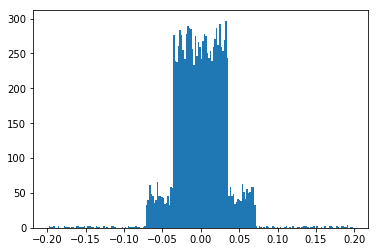

In [54]:
_ = plt.hist(orig_params_flat, bins=200)
plt.show()

In [55]:
final_params = []
for param in best_model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)

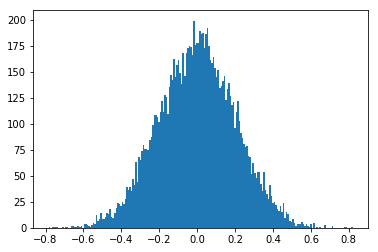

In [56]:
_ = plt.hist(final_params_flat, bins=200)
plt.show()